In [12]:
# 社区成员数据分析

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [13]:
# 配置中文字体和输出目录
plt.rcParams['font.sans-serif'] = [
        'Hiragino Sans GB',   # 冬青黑体（macOS 10.6+ 自带）
        'AppleGothic',        # 苹果儷黑
        'Arial Unicode MS'    # Office安装时自带
    ]
# plt.rcParams['font.sans-serif'] = ['SimHei'] # Windows/Linux 简化配置
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
output_dir = 'analysis_results'
os.makedirs(output_dir, exist_ok=True)

In [14]:
# 数据加载与清洗
df = pd.read_excel('注意保护隐私，只填写必要信息.xlsx',
                  header=1,
                  skiprows=[2],
                  usecols="B:J").dropna(how='all')

In [15]:
# 列名标准化
df.columns = ['昵称', '目标岗位', '原始经验', '邮箱',
             '社交账号', '地区', '目的', '加入意愿', '备注']

# 经验字段处理函数
def parse_experience(exp):
    try:
        if pd.isna(exp):
            return np.nan
        if isinstance(exp, str):
            exp = exp.strip()
            if '实习' in exp:
                return 0.5
            if '+' in exp:
                return float(exp.replace('+', ''))
        return float(exp)
    except:
        return np.nan

df['经验'] = df['原始经验'].apply(parse_experience)
df = df.drop(columns=['原始经验'])

# 数据检查点
print("=== 数据样本检查 ===")
display(df[['昵称', '目标岗位', '经验', '地区', '目的']].head(3))

=== 数据样本检查 ===


,昵称,目标岗位,经验,地区,目的
0,建材AAA王哥,pm,5.0,海外,项目经验
1,王思捷,fullstack,3.0,海外,工作机会
2,Zoe,fullstack/pm,4.5,海外,工作机会/公司挂靠


In [16]:
# 1. 活跃成员分析
active_members = df[df['加入意愿'] == '是'].shape[0]
print(f"\n[活跃成员] 总数：{active_members}/{len(df)}")


[活跃成员] 总数：43/47


In [17]:
# 2. 地域分布分析
plt.figure(figsize=(8, 8))

# 数据清洗
df['地区'] = df['地区'].str[:2].str.strip()

# 处理特殊案例（如"国外"转为"海外"）
df['地区'] = df['地区'].replace({'国外': '海外'})

# 最终有效分类
valid_regions = ['国内', '海外']
df = df[df['地区'].isin(valid_regions)]


print("地区分类统计：")
print(df['地区'].value_counts(dropna=False))

region_counts = df['地区'].value_counts()
n_regions = len(region_counts)  # 现在应该是2

plt.figure(figsize=(8, 8))
region_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff', '#99ff99'][:n_regions],  # 自动匹配颜色数量
    explode=(0.05, 0)[:n_regions],             # 自动截取explode参数
    startangle=90
)
plt.title('成员地域分布（标准化后）')
plt.savefig(f'{output_dir}/region_dist.png', dpi=300, bbox_inches='tight')
plt.close()

地区分类统计：
地区
海外    25
国内    22
Name: count, dtype: int64


<Figure size 800x800 with 0 Axes>

In [18]:
# 3. 目的分布分析（处理多选）
purposes = df['目的'].str.split('/').explode().str.strip().value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=purposes.values, y=purposes.index, palette='viridis')
plt.title('成员主要目的分布')
plt.xlabel('人数')
plt.savefig(f'{output_dir}/purpose_dist.png', dpi=300, bbox_inches='tight')
plt.close()

/var/folders/0j/rwkq_d4d5wx9s7f3g2mlxkj80000gn/T/ipykernel_38827/1953149703.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=purposes.values, y=purposes.index, palette='viridis')


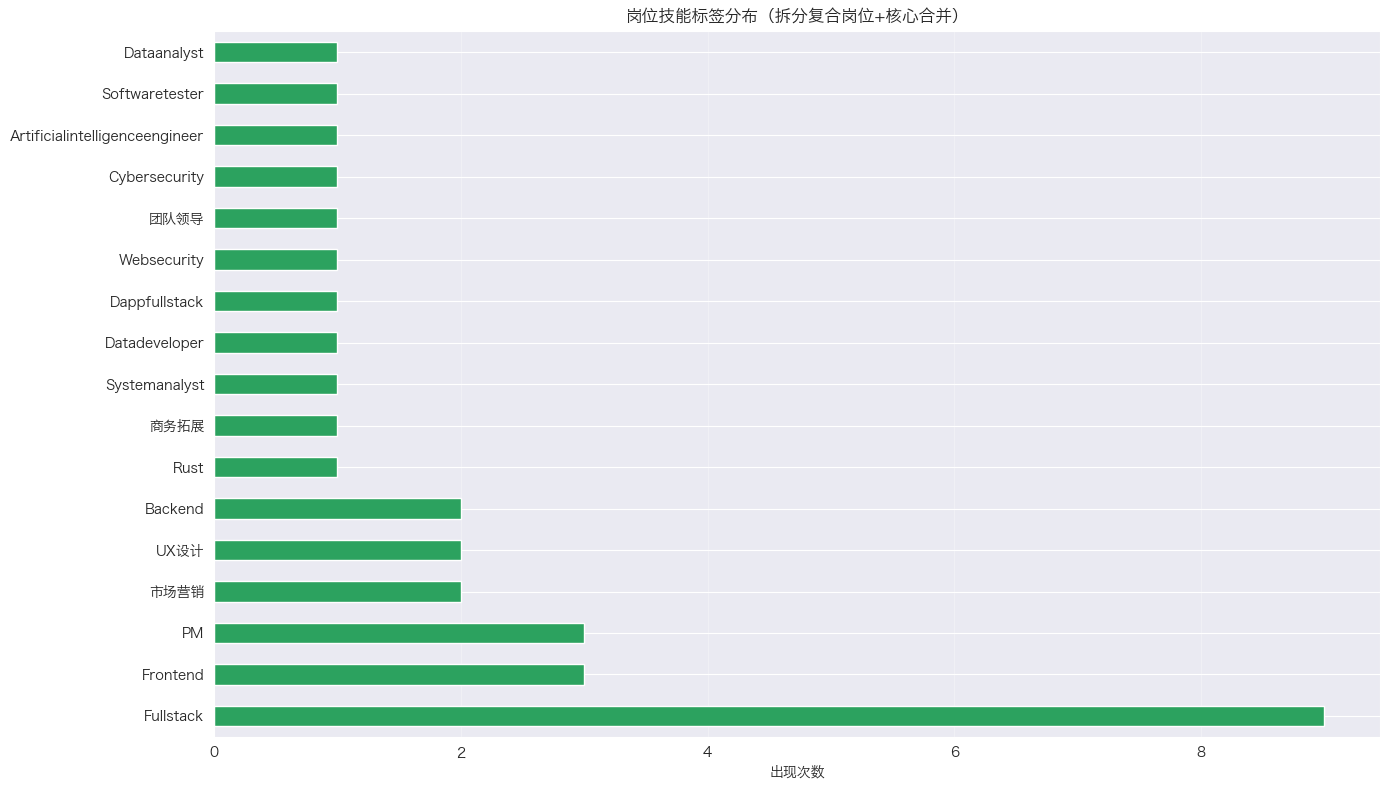

In [19]:
import pandas as pd
import re

# 原始数据示例
data = [
    "Fullstack/Web Security", "Software Tester", "Artificial Intelligence Engineer",
    "Ux/PM", "Cybersecurity", "Fullstack/Tearneader", "Data Developer",
    "Fullstack/Dapp Fullstack", "Frontend/Uux", "Fullstack/Backend",
    "Fullstack/System Analyst", "PM/Bd", "Fullstack/Rust",
    "Frontend/Fullstack", "Marketing/Advertising", "Data Analyst", "PM",
    "Fullstack/Frontend", "Backend", "Fullstack"
]

# 核心合并规则（仅针对需要合并的类别）
merge_map = {
    r'(?i)\bmarketing\b|\badvertising\b': '市场营销',
    r'(?i)\bpm\b|\bproduct manager\bproject manager\b': 'PM',
    r'(?i)\bux\b|\buux\b': 'UX设计',
    r'(?i)\bbd\b': '商务拓展',
    r'(?i)\bdapp\b': '区块链开发',
    r'(?i)\btearneader\b': '团队领导'  # 修正拼写错误
}

# 拆分复合岗位并合并核心类别
def process_positions(pos):
    # 预处理：统一格式
    pos = re.sub(r'\s+', '', pos.lower())

    # 拆分复合岗位
    parts = re.split(r'[/&+,]', pos)

    # 应用合并规则
    cleaned = []
    for part in parts:
        for pattern, category in merge_map.items():
            if re.search(pattern, part):
                cleaned.append(category)
                break
        else:
            cleaned.append(part.title())  # 保留原名称但规范化格式

    return cleaned

# 生成拆分后的标签列表
all_tags = []
for pos in data:
    tags = process_positions(pos)
    all_tags.extend(tags)

# 统计频率
tag_counts = pd.Series(all_tags).value_counts()

# 可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
tag_counts.plot.barh(color='#2ca25f')
plt.title('岗位技能标签分布（拆分复合岗位+核心合并）')
plt.xlabel('出现次数')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/position_dist.png', dpi=300)

plt.show()
plt.close()

In [20]:
# 5. 经验分布分析

# 数据清洗：处理缺失值和文本描述
def clean_experience(exp):
    try:
        # 处理空白/缺失值 → 设为0年
        if pd.isna(exp) or str(exp).strip() == '':
            return 0.0

        # 处理文本描述（如"实习"）
        exp = str(exp).lower()
        if '实习' in exp:
            return 0.5  # 实习单独标记
        if '应届' in exp:
            return 0.0

        # 提取数值（处理"3+", "5年"等格式）
        num = re.findall(r'\d+\.?\d*', exp)
        return float(num[0]) if num else 0.0
    except:
        return 0.0  # 异常值兜底处理

df['经验'] = df['经验'].apply(clean_experience)

bins = [0, 1, 3, 5, 10, np.inf]
labels = ['应届/实习', '1-3年', '3-5年', '5-10年', '10年+']
df['经验分段'] = pd.cut(df['经验'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
exp_dist = df['经验分段'].value_counts().sort_index()
exp_dist.plot(kind='bar', color='#2ca25f')
plt.title('成员经验分布')
plt.xlabel('经验区间')
plt.ylabel('人数')
plt.xticks(rotation=45)
plt.savefig(f'{output_dir}/experience_dist.png', dpi=300, bbox_inches='tight')
plt.close()

In [21]:
# 生成文本报告
report = f"""=== 社区成员分析报告 ===
总成员数：{len(df)}
活跃成员（愿加入工作小组）：{active_members}人 ({active_members/len(df):.1%})

地域分布：
{region_counts.to_string()}

前三大需求目的：
{purposes.head(3).to_string()}

前三大目标岗位：
{tag_counts.head(3).to_string()}

经验分布：
{exp_dist.to_string()}
"""

with open(f'{output_dir}/report.txt', 'w') as f:
    f.write(report)

print(f"\n分析完成！结果已保存至 {output_dir} 目录")


分析完成！结果已保存至 analysis_results 目录
